# GUIA 4 (Hartree-Fock)
## Por Facundo L. Sanchez

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import interpolate
from scipy import integrate
%matplotlib inline
from __future__ import division

## Matriz de Overlap

In [2]:
# Elemento de matriz de overlap
def Overlap_ij(alpha,i,j):
    Sij = ( np.pi / (alpha[i] + alpha[j]) )**(1.5)
    return Sij

# Matriz de overlap
def Matriz_Overlap(alpha):
    nsize = len(alpha)
    S = np.zeros((nsize,nsize))
    for i in range(0,nsize):
        for j in range(i,nsize):        
            S[i,j]=Overlap_ij(alpha,i,j)
            S[j,i]=S[i,j]
    return S

## Matriz del Hamiltoniano

In [3]:
# Elemento de matriz de cinetica
def Tij(alpha,l,i,j):
    rnum = 3 * np.pi**(1.5) * alpha[i] * alpha[j]
    rden = (alpha[i] + alpha[j])**(2.5)    
    Tij = rnum/rden + l*(l+1)*np.pi**(3/2)/(alpha[i]+alpha[j])**0.5
    return Tij

 
# Elemento de matriz de potencial
def Vij(alpha,Z,i,j):
    Vij =  Z*( -2*np.pi )  /  (alpha[i] + alpha[j])    
    return Vij

# Matriz del Hamiltoniano en la base elegida (gaussianos en este caso)
def Matriz_H(alpha,l,Z):
    nsize = len(alpha)
    H = np.zeros((nsize,nsize))
    for i in range(nsize):
        for j in range(i,nsize): 
            H[i,j] = Tij(alpha,l,i,j) + Vij(alpha,Z,i,j)
            H[j,i] = H[i,j]
    return H

## Tensor Q (integrales de 4 gaussianas con diferentes exponentes)

In [4]:
# Elemento de matriz del tensor Q, donde p,r,q,s son las combinaciones de los alphas
def Qprqs(alpha,p,r,q,s):
    num = 2*np.pi**2.5 
    den = (alpha[p]+alpha[q])*(alpha[r]+alpha[s])*(alpha[p]+alpha[q]+alpha[r]+alpha[s])**0.5
    return num/den

# Tensor Q
def Tensor_Q(alpha):
    Iter = range(len(alpha))
    Q = np.array([[[[Qprqs(alpha,p,r,q,s) for p in Iter] for r in Iter] for q in Iter] for s in Iter])
    return Q

## Matriz del operador de Fock

In [5]:
# Construccion del operador de Fock en forma matricial
def F_Matriz(H,Q,Ci):
    size = H.shape[0]
    F = np.zeros(H.shape)
    for i in range(size):
        for j in range(i,size):
            F[i,j] = H[i,j] + Ci.dot(Q[i,:,j,:].dot(Ci))
            F[j,i] = F[i,j]
    return F

## Normalizacion de los coeficientes (via matriz de overlap)

In [6]:
def C_Norm(C,S):
    size = C.shape[0]
    for i in range(size):
        Ci = C[:,i]
        norm = Ci.T.dot(S.dot(Ci))**0.5
        C[:,i] = C[:,i]/norm

## Calculo de la energia de Hartree-Fock

In [7]:
def Energy_Calc(Ci,H,Q):
    Iter = range(Ci.shape[0])
    cumres = 2*Ci.T.dot(H.dot(Ci))
    for p in Iter:
        for r in Iter:
            for q in Iter:
                for s in Iter:
                    cumres = cumres + Ci[p]*Ci[r]*Ci[q]*Ci[s]*Q[p,r,q,s]
    return cumres

## Calculo de la funcion de onda de HF a partir de los coeficientes

In [8]:
def psi(Ci,Alpha,x):
    nsize = len(Ci) 
    res = 0
    for i in range(0,nsize):
        res = res + Ci[i]*np.exp(-Alpha[i]*x**2)
    return res

# He $1s^2$

In [9]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
#alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
#alpha = np.array([0.006,0.05, 0.1, 0.298073,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 2
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [17]:
C = C_new
F = F_Matriz(H,Q,C[:,0])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,0],H,Q)
print "-) Energia Ionizacion:", E[0]
cont += 1

Iteracion Nro: 7
-) Energia Total: -2.8551603823050575
-) Energia Ionizacion: -0.9141143353423429


- La energia total y la de ionizacion dan razonable con lo que se ve en las tablas de Bunge y Johnson

In [18]:
r,psiFunc = np.loadtxt("He_wave.1s",unpack=True)
rmin, rmax = 0, 10
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,0],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,x=r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,x=r)**0.5

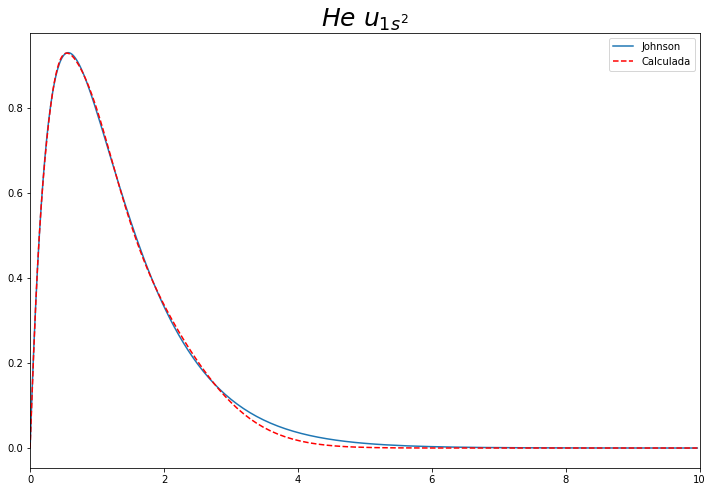

In [19]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$He$ $u_{1s^2}$", size=25)
plt.legend(loc='best')

## Valores medios de r

In [20]:
r_2Mean = np.trapz(psi_calc**2*r**4,r)
r_Mean = np.trapz(psi_calc**2*r**3,r)
r_m1Mean = np.trapz(psi_calc**2*r,r)
r_m2Mean = np.trapz(psi_calc**2,r)
print "<r^2> =",r_2Mean
print "<r> =",r_Mean
print "<r^(-1)> =",r_m1Mean
print "<r^(-2)> =",r_m2Mean

<r^2> = 1.1624857829669006
<r> = 0.9232894699107103
<r^(-1)> = 1.6843513213176633
<r^(-2)> = 5.86288715650706


- OK con tablas de Bunge, aunque se ven diferencias en la primera cifra significativa en $r^2$ y en $\frac{1}{r^2}$, pero me parecieron razonables considerando que la funcion de onda que obtuve no solapa completamente con la de Johnson. Probe hacer Simpson para mejorar el metodo de integracion, pero no mejora mucho el resultado.

## Virial

In [21]:
# Calculo el potencial interelectronico
Vinter = 0
Ci = C_new[:,0]
Iter = range(len(Ci))
for p in Iter:
    for t in Iter:
        for q in Iter:
            for s in Iter:
                Vinter = Vinter + Ci[p]*Ci[t]*Ci[q]*Ci[s]*Q[p,t,q,s]
                
# Cinetica
T = np.trapz(-np.gradient(np.gradient(r*psi_calc,r),r)*psi_calc*r,r)
# Potencial
V = np.trapz(-4*psi_calc**2*r,r) + Vinter
print "Cinetica =",T
print "Potencial =",V
print "Energia Total=",T+V
print "<V>/<T> =",V/T

Cinetica = 2.856680601472933
Potencial = -5.710496911321759
Energia Total= -2.8538163098488263
<V>/<T> = -1.9989973357110242


- OK con tablas de Bunge, nuevamente se observan diferencias pero parece ser razonable

## Kato

In [22]:
np.gradient(psi_calc,r)[0]/psi_calc[0]

-0.00016263172775605528

- No da Kato porque una base Gaussiana nunca va a dar Kato. Pero da ~ 0, que es lo que analiticamente tiene que dar la derivada en r = 0

# He $2s^2$

In [23]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
#alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
#alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
alpha = np.array([0.006,0.05, 0.298073, 0.35 ,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 2
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [30]:
C = C_new
F = F_Matriz(H,Q,C[:,1])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,1],H,Q)
print "-) Energia Ionizacion:", E[1]
cont += 1

Iteracion Nro: 6
-) Energia Total: -0.7175983488198177
-) Energia Ionizacion: -0.2305837121800597


- La energia total y la de ionizacion dan razonable con lo que se ve en Johnson

In [31]:
r,psiFunc = np.loadtxt("He_wave.2s",unpack=True)
rmin, rmax = 0, 20
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,1],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,r)**0.5

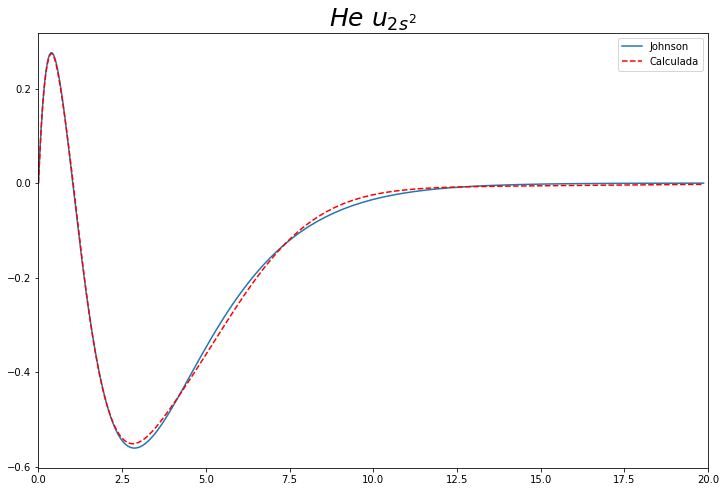

In [32]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$He$ $u_{2s^2}$", size=25)
plt.legend(loc='best')

# $H^-$ $1s^2$

In [33]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
#alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
#alpha = np.array([0.006,0.05, 0.298073, 0.35 ,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 1
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [63]:
C = C_new
F = F_Matriz(H,Q,C[:,0])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,0],H,Q)
print "-) Energia Ionizacion:", E[0]
cont += 1

Iteracion Nro: 29
-) Energia Total: -0.484829728378606
-) Energia Ionizacion: -0.03878844034953663


- Por lo que se puede ver en la tabla 6.3, pag 270 del Bransden y Joachain, la energía exacta para el $H^-$ es -0.528 mientras que la que se obtiene haciendo el variacional simple de la carga efectiva es de -0.473. Por tanto, lo que obtuve es una mejora sobre el variacional simple pero todavia alejado del resultado exacto (por las correlaciones, que discuto un poco mas adelante)

In [64]:
r,psiFunc = np.loadtxt("H_minus_wave.1s",unpack=True)
rmin, rmax = 0, 25
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,0],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,r)**0.5

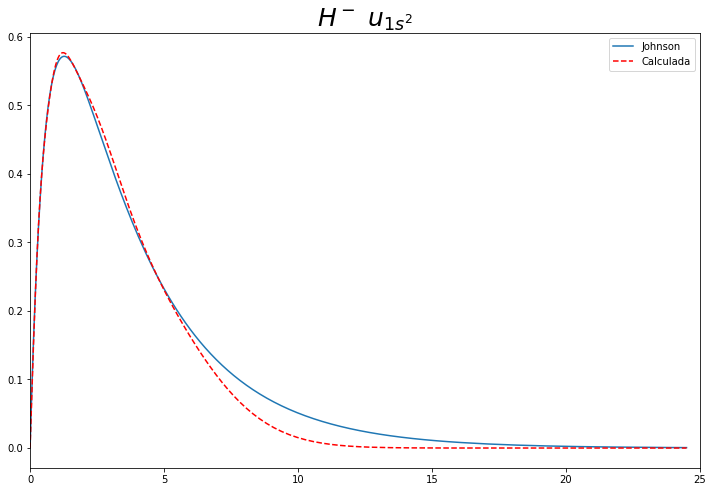

In [65]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$H^-$ $u_{1s^2}$", size=25)
plt.legend(loc='best')

- En el caso del $H^-$ podemos ver que el estado no es ligado ya que tenemos energia mayor que la del H, por lo que HF no puede obtener estados ligados para el $H^-$. Esto es asi porque en el calculo del $H^-$ es muy importante tener en cuenta la correlacion que HF no posee.

# Calculo de propiedades quimicas del Na

In [66]:
E_Na0 = -161.85891157
E_NaMenos = -161.85512594
E_NaMas = -161.68228261

Eaff = E_Na0 - E_NaMenos
print "E_affinity =", Eaff
Eion = E_NaMas - E_Na0
print "E_ionization =", Eion

E_affinity = -0.00378563000001
E_ionization = 0.17662896


- Me estan dando los signos al reves y no entiendo porque. La energia del orbital en Johnson da -0.181801 y en Fischer 0.3642, asi que seguro estoy metiendo la pata con algo. Pero en cualquier caso el Koopman aproxima bastante bien, ya que la energia de ionizacion esta bastante cerca a la del orbital.

In [67]:
electroneg = 0.5*np.abs(Eaff+Eion)
hardness = 0.5*np.abs(Eaff-Eion)
softness = 0.5/hardness
mu = -electroneg
print "Electronegativity =", electroneg
print "Hardness =", hardness
print "Softness =", softness
print "Mu =", mu

Electronegativity = 0.08642166500000314
Hardness = 0.09020729500001323
Softness = 5.542788972886579
Mu = -0.08642166500000314


- En los apuntes de la teorica hay una tabla con los valores absolutos para el Na:
    - electronegatividad = 0.1048 a.u. 
    - hardness = 0.0846 a.u.
- Si bien a mi me dio electronegatividad < hardness, los valores que obtuve no estan muy alejados de los experimentales

# Con respecto al 1s2s del He, no supe bien como plantearlo. Lo mismo me pasó con las ecuaciones para el fundamental del B, lo que no entiendo concretamente es en que parte del procedimiento elijo trabajar en el fundamental